# RAG Demo
Note: Code mostly copied from LangChain's tutorial https://python.langchain.com/docs/tutorials/rag/

This tutorial will show you how to implement a simple RAG pipeline.

# Setup

In [1]:
%%capture
!pip install -qU langchain
!pip install --quiet langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-chroma
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install -qU pypdf
!pip install -q fixthaipdf

In [2]:
import os
import getpass

os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Gemini API key: ")

Enter your Gemini API key: ··········


# Code

## Components

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

## Indexing

### Loading documents

We will be using CR99 from Reg Chula as our document. To load this pdf, we will use `PyPDFLoader`.

You can download the document here: https://www.reg.chula.ac.th/CR99_2024Th.pdf

In [6]:
from langchain_community.document_loaders import PyPDFLoader
from fixthaipdf import clean

file_path = (
    "/content/CR99_2024Th.pdf"
)
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

pages[0]

Document(metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2024-08-26T08:56:17+00:00', 'title': 'CR90', 'moddate': '2024-08-28T16:46:33+07:00', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'author': 'Busaba Cheunjit', 'source': '/content/CR99_2024Th.pdf', 'total_pages': 37, 'page': 0, 'page_label': '1'}, page_content='จท 99\n \n คู\x00มือนิสิตเกี่ยวกับงานทะเบียนนิสิต\nป \x00 ก า ร ศ ึ ก ษ า  2567')

In [7]:
for page in pages:
  page.page_content = clean(page.page_content)

In [8]:
print(pages[0])

page_content='จท 99
คู มือนิสิตเกี่ยวกับงานทะเบียนนิสิต
ป   การ ศึก ษา 2567' metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2024-08-26T08:56:17+00:00', 'title': 'CR90', 'moddate': '2024-08-28T16:46:33+07:00', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'author': 'Busaba Cheunjit', 'source': '/content/CR99_2024Th.pdf', 'total_pages': 37, 'page': 0, 'page_label': '1'}


### Splitting documents

Our loaded document is too long to fit
into the context window of many models. Even for those models that could
fit the full post in their context window, models can struggle to find
information in very long inputs.

To handle this we’ll split the `Document`s into chunks for embedding and
vector storage. This should help us retrieve only the most relevant parts
of the blog post at run time.

We use a
[RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),
which will recursively split the document using common separators like
new lines until each chunk is the appropriate size. This is the
recommended text splitter for generic text use cases.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # chunk size (characters)
    chunk_overlap=200,      # chunk overlap (characters)
    add_start_index=True,   # track index in original document
)
all_splits = text_splitter.split_documents(pages)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 92 sub-documents.


### Storing documents

Now we need to index our 92 text chunks so that we can search over them
at runtime. Our approach is to [embed](https://python.langchain.com/docs/concepts/embedding_models/) the contents of each document split and insert these embeddings
into a [vector store](https://python.langchain.com/docs/concepts/vectorstores/). Given an input query, we can then use
vector search to retrieve relevant documents.

We can embed and store all of our document splits in a single command
using the vector store and embeddings model selected at the [start of the tutorial](https://python.langchain.com/docs/tutorials/rag/#components).

In [10]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

['b80124a1-4c5e-4768-9c1c-ed05bb66d9b4', '5cec04df-8457-4667-aadc-21be20a572bd', '4393197b-cc27-4e78-8d26-9890870c973b']


## Retrieval and Generation

Now let’s write the actual application logic. We want to create a simple
application that takes a user question, searches for documents relevant
to that question, passes the retrieved documents and initial question to
a model, and returns an answer.

For generation, we will use the chat model selected at the [start of the tutorial](https://python.langchain.com/docs/tutorials/rag/#components).

We’ll use a prompt for RAG that is checked into the LangChain prompt hub
([here](https://smith.langchain.com/hub/rlm/rag-prompt)).

Note: LangSmith API key is required for pulling the prompt from hub.

- LangSmith API Key : [smith.langchain.com](https://smith.langchain.com)


In [11]:
# langsmith API key for pulling prompt template
import os
from getpass import getpass
LANGSMITH_API_KEY=getpass("LANGSMITH_API_KEY:")

LANGSMITH_API_KEY:··········


In [13]:
from langsmith import Client
client = Client(api_key=LANGSMITH_API_KEY)
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll use [LangGraph](https://langchain-ai.github.io/langgraph/) to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We get streamlined deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/).
- LangSmith will automatically trace the steps of our application together.
- We can easily add key features to our application, including [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) and [human-in-the-loop approval](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/), with minimal code changes.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

### State:

The [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a `TypedDict`, but can also be a [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/).

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [14]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Nodes (application steps)

Let's start with a simple sequence of two steps: retrieval and generation.

In [15]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

### Control flow

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

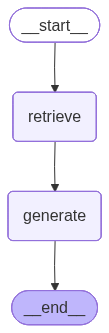

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Usage

Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

Invoke:

In [18]:
question = "บัตรนิสิตหายต้องทำยังไง"

In [19]:
result = graph.invoke({"question": question})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='92579e9c-7a58-44ec-9673-52bdfd4dc266', metadata={'moddate': '2024-08-28T16:46:33+07:00', 'start_index': 0, 'source': '/content/CR99_2024Th.pdf', 'author': 'Busaba Cheunjit', 'page': 10, 'creationdate': '2024-08-26T08:56:17+00:00', 'producer': 'Canva', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'creator': 'Canva', 'page_label': '11', 'total_pages': 37, 'title': 'CR90'}, page_content='การขอออกบัตรประจำตัวนิสิต (สำหรับนิสิตใหม่ : ใบแรก)\nนิสิตใหม่จะสามารถขอออกบัตรประจำตัวนิสิตได้เมื่อ “ผลการตรวจสอบรูปถ่ายและบัตรประชาชนใน\nการลงทะเบียนแรกเข้าถูกต้องครบถ้วน รวมทั้ง “นิสิตลงทะเบียนแรกเข้าออนไลน์ (เอกสารถูกต้องครบถ้วน)\nลงทะเบียนเรียนและชำระค่าเล่าเรียนเรียบร้อย” (มีสถานภาพเป็นนิสิตโดยสมบูรณ์)\nโดยให้ดำเนินการขอออกบัตรนิสิตที่แอพ CUNEX และต้องมีบัญชีออมทรัพย์ของธนาคารกสิกรไทย\n1. นิสิตกดขอออกบัตรนิสิต ผ่านเมนู “บัตรประจำตัวนิสิต” ใน CUNEX Application\n2. ระบุที่อยู่จัดส่งบน K PLUS หรือเลือกไปรับที่สาขา\n3. รอรับบัตรประจำตัวนิสิตตามที่อยู่จัดส่งหรือที่สาขา\nการขอทำบัตรประจำต

Stream steps:

In [20]:
for step in graph.stream(
    {"question": question}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='92579e9c-7a58-44ec-9673-52bdfd4dc266', metadata={'page': 10, 'source': '/content/CR99_2024Th.pdf', 'total_pages': 37, 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'creator': 'Canva', 'moddate': '2024-08-28T16:46:33+07:00', 'start_index': 0, 'title': 'CR90', 'producer': 'Canva', 'author': 'Busaba Cheunjit', 'creationdate': '2024-08-26T08:56:17+00:00', 'page_label': '11'}, page_content='การขอออกบัตรประจำตัวนิสิต (สำหรับนิสิตใหม่ : ใบแรก)\nนิสิตใหม่จะสามารถขอออกบัตรประจำตัวนิสิตได้เมื่อ “ผลการตรวจสอบรูปถ่ายและบัตรประชาชนใน\nการลงทะเบียนแรกเข้าถูกต้องครบถ้วน รวมทั้ง “นิสิตลงทะเบียนแรกเข้าออนไลน์ (เอกสารถูกต้องครบถ้วน)\nลงทะเบียนเรียนและชำระค่าเล่าเรียนเรียบร้อย” (มีสถานภาพเป็นนิสิตโดยสมบูรณ์)\nโดยให้ดำเนินการขอออกบัตรนิสิตที่แอพ CUNEX และต้องมีบัญชีออมทรัพย์ของธนาคารกสิกรไทย\n1. นิสิตกดขอออกบัตรนิสิต ผ่านเมนู “บัตรประจำตัวนิสิต” ใน CUNEX Application\n2. ระบุที่อยู่จัดส่งบน K PLUS หรือเลือกไปรับที่สาขา\n3. รอรับบัตรประจำตัวนิสิตตามที่อยู่จัดส่งหรือที่สาขา\nก

Stream tokens

In [21]:
for message, metadata in graph.stream(
    {"question": question}, stream_mode="messages"
):
    print(message.content, end="|")

หากบัตรนิสิตหาย สามารถยื่นคำร้องขอทำบัตรใหม่ได้ผ่านสำนักงานการทะเบียน, เว็บไซต์สำนักงานการทะเบียน หรือ CUNEX Application. คุณจะต้องกรอกคำร้อง จท50 และชำ|ระค่าธรรมเนียม 100 บาท. จากนั้นจะได้รับเอกสารเพื่อนำไปติดต่อขอรับบัตรใหม่ที่ธนาคารกสิกรไทย 5 สาขาที่กำหนด โดยแสดงหลักฐาน เช่น บัตรประชาชน| และสมุดบัญชีธนาคารกสิกรไทย.||

For async invocations, use:

```python
result = await graph.ainvoke(...)
```

and

```python
async for step in graph.astream(...):
```

# Agentic RAG

Conversational experiences can be naturally represented using a sequence of [messages](https://python.langchain.com/docs/concepts/messages/). In addition to messages from the user and assistant, retrieved documents and other artifacts can be incorporated into a message sequence via [tool messages](https://python.langchain.com/docs/concepts/messages/#toolmessage). This motivates us to represent the state of our RAG application using a sequence of messages. Specifically, we will have

1. User input as a `HumanMessage`;
2. Vector store query as an `AIMessage` with tool calls;
3. Retrieved documents as a `ToolMessage`;
4. Final response as a `AIMessage`.

This model for state is so versatile that LangGraph offers a built-in version for convenience:

In [22]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

Leveraging [tool-calling](https://python.langchain.com/docs/concepts/tool_calling/) to interact with a retrieval step has another benefit, which is that the query for the retrieval is generated by our model. This is especially important in a conversational setting, where user queries may require contextualization based on the chat history. For instance, consider the following exchange:

> Human: "What is Task Decomposition?"
>
> AI: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."
>
> Human: "What are common ways of doing it?"

In this scenario, a model could generate a query such as `"common approaches to task decomposition"`. Tool-calling facilitates this naturally. This allows a model to rewrite user queries into more effective search queries. It also provides support for direct responses that do not involve a retrieval step (e.g., in response to a generic greeting from the user).

Let's turn our retrieval step into a [tool](https://python.langchain.com/docs/concepts/tools):

In [23]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query from a vector database containing information on student's handbook."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will consist of three nodes:

1. A node that fields the user input, either generating a query for the retriever or responding directly;
2. A node for the retriever tool that executes the retrieval step;
3. A node that generates the final response using the retrieved context.

We build them below. Note that we leverage another pre-built LangGraph component, [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode), that executes the tool and adds the result as a `ToolMessage` to the state.

In [24]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [25]:
# Step 2: Execute the retrieval.
# The ToolNode is roughly analogous to:

# tools_by_name = {tool.name: tool for tool in tools}
# def tool_node(state: dict):
#     result = []
#     for tool_call in state["messages"][-1].tool_calls:
#         tool = tools_by_name[tool_call["name"]]
#         observation = tool.invoke(tool_call["args"])
#         result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
#     return {"messages": result}

tools = ToolNode([retrieve])

In [26]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the steps into a sequence. We also allow the first `query_or_respond` step to "short-circuit" and respond directly to the user if it does not generate a tool call. This allows our application to support conversational experiences-- e.g., responding to generic greetings that may not require a retrieval step

In [27]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

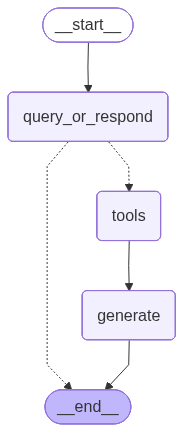

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Stateful management of chat history

To manage multiple conversational turns and threads, all we have to do is specify a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/) when compiling our application. Because the nodes in our graph are appending messages to the state, we will retain a consistent chat history across invocations.

LangGraph comes with a simple in-memory checkpointer, which we use below. See its [documentation](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).

For a detailed walkthrough of how to manage message history, head to the [How to add message history (memory)](/docs/how_to/message_history) guide.

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver() # to support multi-turn conversation
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

We can now invoke similar to before:

In [30]:
input_message = "บัตรนิสิตหายต้องทำยังไง"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

บัตรนิสิตหายต้องทำยังไง
================================== Ai Message ==================================
Tool Calls:
  retrieve (2c793516-7706-46a8-b2a1-4024a037060b)
 Call ID: 2c793516-7706-46a8-b2a1-4024a037060b
  Args:
    query: บัตรนิสิตหาย
================================= Tool Message =================================
Name: retrieve

Source: {'page': 10, 'start_index': 0, 'moddate': '2024-08-28T16:46:33+07:00', 'total_pages': 37, 'author': 'Busaba Cheunjit', 'creator': 'Canva', 'producer': 'Canva', 'title': 'CR90', 'page_label': '11', 'creationdate': '2024-08-26T08:56:17+00:00', 'source': '/content/CR99_2024Th.pdf', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc'}
Content: การขอออกบัตรประจำตัวนิสิต (สำหรับนิสิตใหม่ : ใบแรก)
นิสิตใหม่จะสามารถขอออกบัตรประจำตัวนิสิตได้เมื่อ “ผลการตรวจสอบรูปถ่ายและบัตรประชาชนใน
การลงทะเบียนแรกเข้าถูกต้องครบถ้วน รวมทั้ง “นิสิตลงทะเบียนแรกเข้าออนไลน์ (เอกสารถูกต้องครบถ้วน)
ลงทะเบี

In [31]:
input_message = "5 สาขาที่ว่านี่อะไรบ้าง"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

5 สาขาที่ว่านี่อะไรบ้าง
================================== Ai Message ==================================

5 สาขาของธนาคารกสิกรไทยที่คุณสามารถไปรับบัตรนิสิตได้แก่ สาขาจามจุรีสแควร์, สยามสแควร์, โรงพยาบาลจุฬาลงกรณ์, เอ็มบีเคเซ็นเตอร์ และสามย่านมิตรทาวน์
